# Computer Vision Face Detection

---

## Importing Python packages

Start by importing the Python packages that you need.

In the following code:

- *matplotlib* provides plotting functions
- *skimage* represents scikit-image, which provides several useful image manipulation tools
- *boto3* represents the AWS SDK for Python (Boto3), which is the Python library for AWS
- *numpy* represents NumPy, which is a library for manipulating data
- *PIL* represents the Python Imaging Library, which contains a set of tools for drawing images


In [81]:
from skimage import io
from skimage.transform import rescale
from matplotlib import pyplot as plt

import boto3

import numpy as np

from PIL import Image, ImageDraw, ImageColor, ImageOps


## Creating a collection

Create a collection in Amazon Rekognition.

You only need to run this step once.


In [84]:
client = boto3.client('rekognition')
collection_id = 'Collection'
response = client.create_collection(CollectionId=collection_id)
print('Collection ARN: ' + response['CollectionArn'])
print('Status Code:' + str(response['StatusCode']))
print('Done...')

ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreateCollection operation: The collection id: Collection already exists

## Task 2: Uploading an image to search

Look at the image by running the cell.


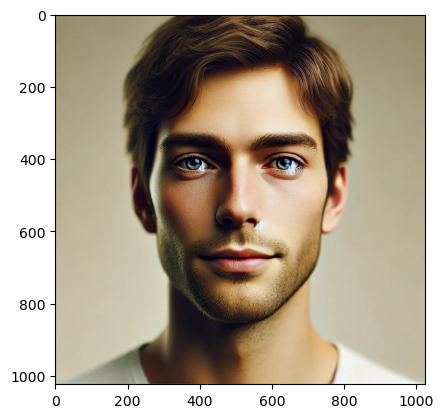

In [88]:
myimages = {"img4.jpg", "img2.jpg", "img3.jpg", "img1.jpg", "img5.jpg"}
for filename in myimages:
    faceimage = io.imread(filename)

    plt.imshow(faceimage)


## Adding the image to the collection

Add the image to the collection created earlier.


In [89]:
for filename in myimages:
    externalimageid = filename

with open(filename, 'rb') as fimage:
    response = client.index_faces(CollectionId = collection_id,
                             Image={'Bytes': fimage.read()},
                             ExternalImageId=externalimageid,
                             MaxFaces=1,
                             QualityFilter="AUTO",
                             DetectionAttributes=['ALL'])

print('Results for ' + filename)
print('Faces indexed:')
for faceRecord in response['FaceRecords']:
     print('  Face ID: ' + faceRecord['Face']['FaceId'])
     print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))

print('Faces not indexed:')
for unindexedFace in response['UnindexedFaces']:
    print(' Location: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
    print(' Reasons:')
    for reason in unindexedFace['Reasons']:
        print('   ' + reason)

Results for img2.jpg
Faces indexed:
  Face ID: 5b598673-d328-4d1e-8042-ac52da50a507
  Location: {'Width': 0.4906477928161621, 'Height': 0.6683014035224915, 'Left': 0.2539721727371216, 'Top': 0.140285924077034}
Faces not indexed:


## Viewing the bounding box for the detected face

If a face was found, the results should include the location of the face that was detected.


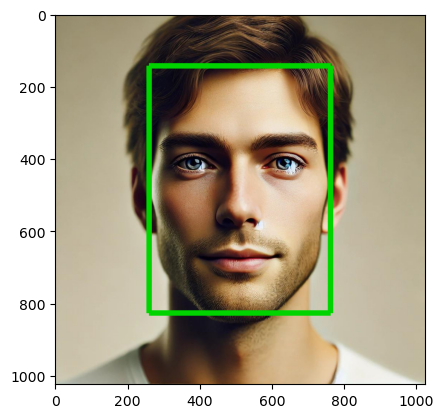

In [90]:

img = Image.open(filename)
imgWidth, imgHeight = img.size

draw = ImageDraw.Draw(img)
for faceRecord in response['FaceRecords']:
    box = faceRecord['Face']['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']

    points = ((left,top),(left+width,top),(left+width,top+height),(left,top+height),(left,top))

    draw.line(points,fill='#00d400', width=15)
    
plt.imshow(img)

## Listing faces in the collection

Examine the image in the collection. 



In [91]:
maxResults=7
faces_count=0
tokens=True

response=client.list_faces(CollectionId=collection_id,
                           MaxResults=maxResults)

print('Faces in collection ' + collection_id)

while tokens:

    faces=response['Faces']

    for face in faces:
        print (face)
        faces_count+=7
    if 'NextToken' in response:
        nextToken=response['NextToken']
        response=client.list_faces(CollectionId=collection_id,
                                   NextToken=nextToken,MaxResults=maxResults)
    else:
        tokens=False

Faces in collection Collection
{'FaceId': '5b598673-d328-4d1e-8042-ac52da50a507', 'BoundingBox': {'Width': 0.4906480014324188, 'Height': 0.668300986289978, 'Left': 0.25397199392318726, 'Top': 0.14028599858283997}, 'ImageId': '973bc57f-6246-3754-aff4-fb83e979cea5', 'ExternalImageId': 'img2.jpg', 'Confidence': 99.9999008178711, 'IndexFacesModelVersion': '7.0'}


## Finding a face by using the collection

Use the collection to detect a face in an image.

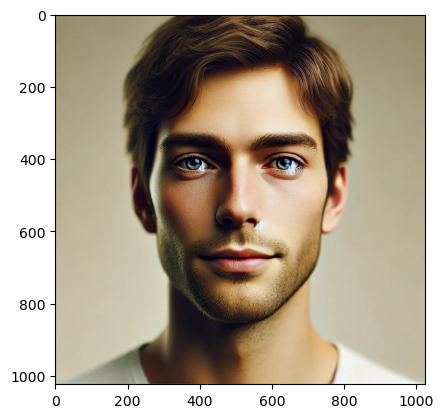

In [93]:
targetfilename = "img2.jpg"

targetimage = Image.open(targetfilename)
plt.imshow(targetimage)

Call the `search_faces_by_image` operation and see if there is a match.

In [94]:
threshold = 70
maxFaces=7

with open(targetfilename, 'rb') as timage:        
    response2=client.search_faces_by_image(CollectionId=collection_id,
                            Image={'Bytes': timage.read()},
                            FaceMatchThreshold=threshold,
                            MaxFaces=maxFaces)

faceMatches=response2['FaceMatches']
print ('Matching faces')
for match in faceMatches:
        print ('FaceId:' + match['Face']['FaceId'])
        print ('Similarity: ' + "{:.2f}".format(match['Similarity']) + "%")
        print ('ExternalImageId: ' + match['Face']['ExternalImageId'])
        print

Matching faces
FaceId:5b598673-d328-4d1e-8042-ac52da50a507
Similarity: 100.00%
ExternalImageId: img2.jpg


## Task 7: Drawing a bounding box around the discovered face

Draw a bounding box around the discovered face.

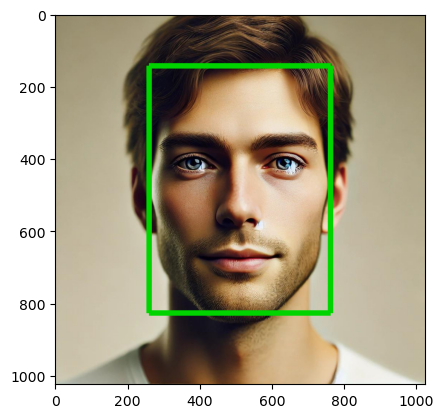

In [95]:
imgWidth, imgHeight = targetimage.size

draw = ImageDraw.Draw(targetimage)

box = response2['SearchedFaceBoundingBox']
left = imgWidth * box['Left']
top = imgHeight * box['Top']
width = imgWidth * box['Width']
height = imgHeight * box['Height']

points = ((left,top),(left+width,top),(left+width,top+height),(left,top+height),(left,top))
draw.line(points,fill='#00d400', width=15)
    
plt.imshow(targetimage)

## Task 8: Deleting the collection

When you are finished, delete the collection. To do this, run the following code. 


In [96]:
print('Attempting to delete collection ' + collection_id)
status_code=0
try:
    response=client.delete_collection(CollectionId=collection_id)
    status_code=response['StatusCode']
    print('All done!')
    print(status_code)
    
except ClientError as e:
    if e.response['Error']['Code'] == 'ResourceNotFoundException':
        print ('The collection ' + collection_id + ' was not found ')
    else:
        print ('Error other than Not Found occurred: ' + e.response['Error']['Message'])
    status_code=e.response['ResponseMetadata']['HTTPStatusCode']



Attempting to delete collection Collection
All done!
200


# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.

Observations
Part 1: Face Detection

Images with Faces:

The system accurately detected and indexed all faces in the images with multiple faces.
For images with single faces, detection was precise, with correct boundaries around the face.
No false positives or missed faces were observed.

Images with No Faces:

The system correctly identified that no faces were present in the image.
The output was appropriate, confirming "no faces detected."
There were no false positives in images with no faces.

